# Mental health Sentiment Analisis using NLP 

In [1]:
# Importing some libraries to use in this notebook 
import pandas as pd 
import numpy as np
import seaborn as sns 
import spacy
import sklearn
import kaggle 
import matplotlib.pyplot as plt
import wordcloud
from wordcloud import WordCloud, STOPWORDS, ImageColorGenerator  

**Dataset selection**
I am using a dataset from kaggle, so to get the dataset, I will use the kaggle API.

In [2]:
kaggle.api.authenticate()
!kaggle datasets list -s 'sentiment-analysis-for-mental-health'

ref                                                             title                                                    size  lastUpdated                 downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------  -------------------------------------------------  ----------  --------------------------  -------------  ---------  ---------------  
suchintikasarkar/sentiment-analysis-for-mental-health           Sentiment Analysis for Mental Health                 11587194  2024-07-05 13:58:31.213000          18357        211  1.0              
bhavikjikadara/mental-health-dataset                            Mental Health Dataset                                 2048887  2024-03-18 06:05:16.487000          17693        147  1.0              
reihanenamdari/mental-health-corpus                             Mental Health Corpus                                  4971088  2023-01-04 01:56:41.113000           6263         79  1.0              
miche

No se pudo analizar el valor especificado en una clave del Registro de ejecuci�n autom�tica.


In [3]:
# # This part is to download the dataset, it can be uncommented to run it.
# !kaggle datasets download -d suchintikasarkar/sentiment-analysis-for-mental-health -p ../data
# import zipfile
# import os

# zip_path = "../data/sentiment-analysis-for-mental-health.zip"
# extract_dir = "../data/mental_health"

# with zipfile.ZipFile(zip_path, 'r') as zip_ref:
#     zip_ref.extractall(extract_dir)

In [4]:
# Opening dataset to see the structure of the data and features         
df_mh = pd.read_csv("../data/mental_health/Combined Data.csv")
df_mh.head()

,Unnamed: 0,statement,status
0,0,oh my gosh,Anxiety
1,1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,3,I've shifted my focus to something else but I'...,Anxiety
4,4,"I'm restless and restless, it's been a month n...",Anxiety


In [5]:
# Unnamed:0 is not useful, thus I will drop the column 
df_mh.drop(columns=['Unnamed: 0'], inplace=True)
df_mh

,statement,status
0,oh my gosh,Anxiety
1,"trouble sleeping, confused mind, restless hear...",Anxiety
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety
3,I've shifted my focus to something else but I'...,Anxiety
4,"I'm restless and restless, it's been a month n...",Anxiety
...,...,...
53038,Nobody takes me seriously I’ve (24M) dealt wit...,Anxiety
53039,"selfishness ""I don't feel very good, it's lik...",Anxiety
53040,Is there any way to sleep better? I can't slee...,Anxiety
53041,"Public speaking tips? Hi, all. I have to give ...",Anxiety


## Data Preparation and cleaning
I will use pandas to read the dataset and do some basic cleaning. 
- See the categories of the dataset
- See the number of rows and columns
    - See if the dataset is balanced 
- Remove duplicates and null values

In [6]:
count = df_mh['status'].value_counts()
print(count)

status
Normal                  16351
Depression              15404
Suicidal                10653
Anxiety                  3888
Bipolar                  2877
Stress                   2669
Personality disorder     1201
Name: count, dtype: int64


In [7]:
(count.values/count.sum())

array([0.30825934, 0.2904059 , 0.20083706, 0.07329902, 0.05423901,
       0.05031767, 0.02264201])

In [8]:
df_mh.isna().sum()

statement    362
status         0
dtype: int64

In this case I will remove the null values, as no statemnt will not add to the model, and is difficult to handle.
As it can be seen, the dataset is not balanced, however, I will use different techniques to handle the imbalance, such as oversampling and undersampling and SMOTE.

In [9]:
df_mh[df_mh.statement.isna() == True].status.value_counts()

status
Personality disorder    124
Bipolar                 100
Stress                   82
Anxiety                  47
Normal                    8
Suicidal                  1
Name: count, dtype: int64

In this case the category with less data is the one with most missing values. In this case maybe doing undersampling could affect the model performance. However I will try this naive apporach to see how it performs. and then I will do other inabalanced data approaches.

In [10]:
df_mh_unproceesed = df_mh.copy()
df_mh.dropna(inplace=True)
df_mh.info()

<class 'pandas.core.frame.DataFrame'>
Index: 52681 entries, 0 to 53042
Data columns (total 2 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   statement  52681 non-null  object
 1   status     52681 non-null  object
dtypes: object(2)
memory usage: 1.2+ MB


status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64


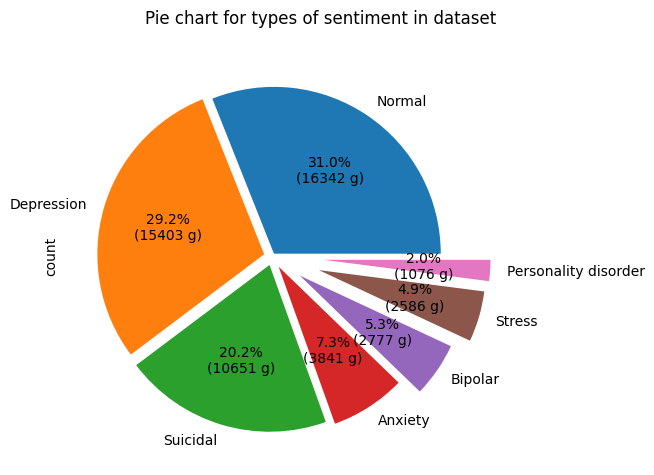

In [11]:
count = df_mh.status.value_counts()

def pct_fct(pct,values):
    absolute = int(pct/100*(values.sum()))
    return "{:.1f}%\n({:d} g)".format(pct, absolute)


print(count)
count.plot(kind='pie', autopct = lambda pct: pct_fct(pct, count), explode =(count.values/count.sum())[::-1])
plt.suptitle('Pie chart for types of sentiment in dataset')
plt.tight_layout()
plt.show()

Now that I have a dataset with balanced classes I will clean the text data with preprocessing techniques such as:
- Lowercasing
- Removing punctuation
- Removing stopwords
- Lemmatization

In [12]:
nlp = spacy.load('en_core_web_sm')
import re
## work in better prerpocessing 
def preprocessing(text):
    """
        This function takes a string and applies the tokenization to remove punctuation, stop words and applies lemmatization 
    """
    text = text.lower()  # Lowercase text
    text = re.sub(r'\[.*?\]', '', text)  # Remove text in square brackets
    text = re.sub(r'<.*?>+', '', text)  # Remove HTML tags
    text = re.sub(r'\n', '', text)  # Remove newlines
    text = re.sub(r'\w*\d\w*', '', text)  # Remove words containing numbers
    processed_text = [token.lemma_ for token in nlp(text) if not token.is_stop and not token.is_punct and not token.like_url and not token.like_email]
    return ' '.join(processed_text)


In [13]:
print(df_mh.statement[28882])

print(preprocessing(df_mh.statement[28882]))

I debated for ten minutes what I should do. I didn't want to open the message completely and violate her trust that far, so I woke her up (which was a big decision because she loves sleep and has two tests today - I know I'm an asshole but she understands and doesn't want me going crazy while she sleeps), and yeah. That was that. She told the guy she was in a relationship (who doesn't check relationship status on Facebook ffs? ), and thanked him for creating a shitstorm.
debate minute want open message completely violate trust far wake big decision love sleep test today know asshole understand want go crazy sleep yeah tell guy relationship check relationship status facebook ffs thank create shitstorm


In [14]:
df_mh['proc_statement']= df_mh['statement'].apply(preprocessing)

In [15]:
df_mh.to_csv('../data/mental_health/preprocessed_mental_health_data.csv')

## Preproccessing

### Undersampling
I will first try to handle imbalanced data with under-sampling.

In [16]:
# Getting random sample for the categories vased on the least amount of data in a category for a balanced dataset 

seed = 200
min_samples= 1077 
df_normal = df_mh[df_mh.status == 'Normal'].sample(1077,random_state=seed)
df_depression = df_mh[df_mh.status == 'Depression'].sample(1077,random_state=seed)
df_suicidal = df_mh[df_mh.status == 'Suicidal'].sample(1077,random_state=seed)
df_anxiaety = df_mh[df_mh.status == 'Anxiety'].sample(1077,random_state=seed)
df_bipolar = df_mh[df_mh.status == 'Bipolar'].sample(1077,random_state=seed)
df_stress = df_mh[df_mh.status == 'Stress'].sample(1077,random_state=seed)
df_per_dis = df_mh[df_mh.status == 'Personality disorder'].sample(1077,random_state=seed)

In [17]:
df_balanced = pd.concat([df_normal, df_depression, df_suicidal,df_anxiaety,
                         df_bipolar, df_stress,df_per_dis], axis=0)
df_balanced.status.value_counts()

status
Normal                  1077
Depression              1077
Suicidal                1077
Anxiety                 1077
Bipolar                 1077
Stress                  1077
Personality disorder    1077
Name: count, dtype: int64

In [18]:
#df_balanced['proc_statement']=df_balanced.statement.apply(preprocessing)
df_balanced 

,statement,status,proc_statement
5399,HSGSHAHA mabait c sir sub nde,Normal,hsgshaha mabait c sir sub nde
31669,how smart are you?,Normal,smart
41844,maddyva thanks a lot learned a lot of new word...,Normal,maddyva thank lot learn lot new word didn t fi...
1417,"""Whoever sells with two sales in one transacti...",Normal,sell sale transaction low price usury hr abu d...
28882,I debated for ten minutes what I should do. I ...,Normal,debate minute want open message completely vio...
...,...,...,...
51031,am happy but also worried about the warmer wea...,Personality disorder,happy worried warm weather start warm spring c...
51593,"Interview anxiety Hi all,\n\nI’ve been job sea...",Personality disorder,interview anxiety hi i’ve job search august of...
51554,Can you relate to these? I wanna know if you g...,Personality disorder,relate wanna know guy relate point try speak l...
51524,"My friend text me, I managed 1 reply before ig...",Personality disorder,friend text manage reply ignore feel awful p...


In [19]:
target = {"Normal"                :0, 
           "Depression"           :1,
           "Suicidal"             :2,
           "Anxiety"              :3,
           "Bipolar"              :4,
           "Stress"               :5,
           "Personality disorder" :6}

In [20]:
df_balanced.drop(columns=['statement'],inplace=True)
df_balanced['category_num'] = df_balanced.status.map(target)
df_balanced

,status,proc_statement,category_num
5399,Normal,hsgshaha mabait c sir sub nde,0
31669,Normal,smart,0
41844,Normal,maddyva thank lot learn lot new word didn t fi...,0
1417,Normal,sell sale transaction low price usury hr abu d...,0
28882,Normal,debate minute want open message completely vio...,0
...,...,...,...
51031,Personality disorder,happy worried warm weather start warm spring c...,6
51593,Personality disorder,interview anxiety hi i’ve job search august of...,6
51554,Personality disorder,relate wanna know guy relate point try speak l...,6
51524,Personality disorder,friend text manage reply ignore feel awful p...,6


C:\Users\hecma\AppData\Local\Temp\ipykernel_24436\92228072.py:19: UserWarning: The figure layout has changed to tight
  plt.tight_layout(pad=1.0, h_pad=0.5, w_pad=1.0)


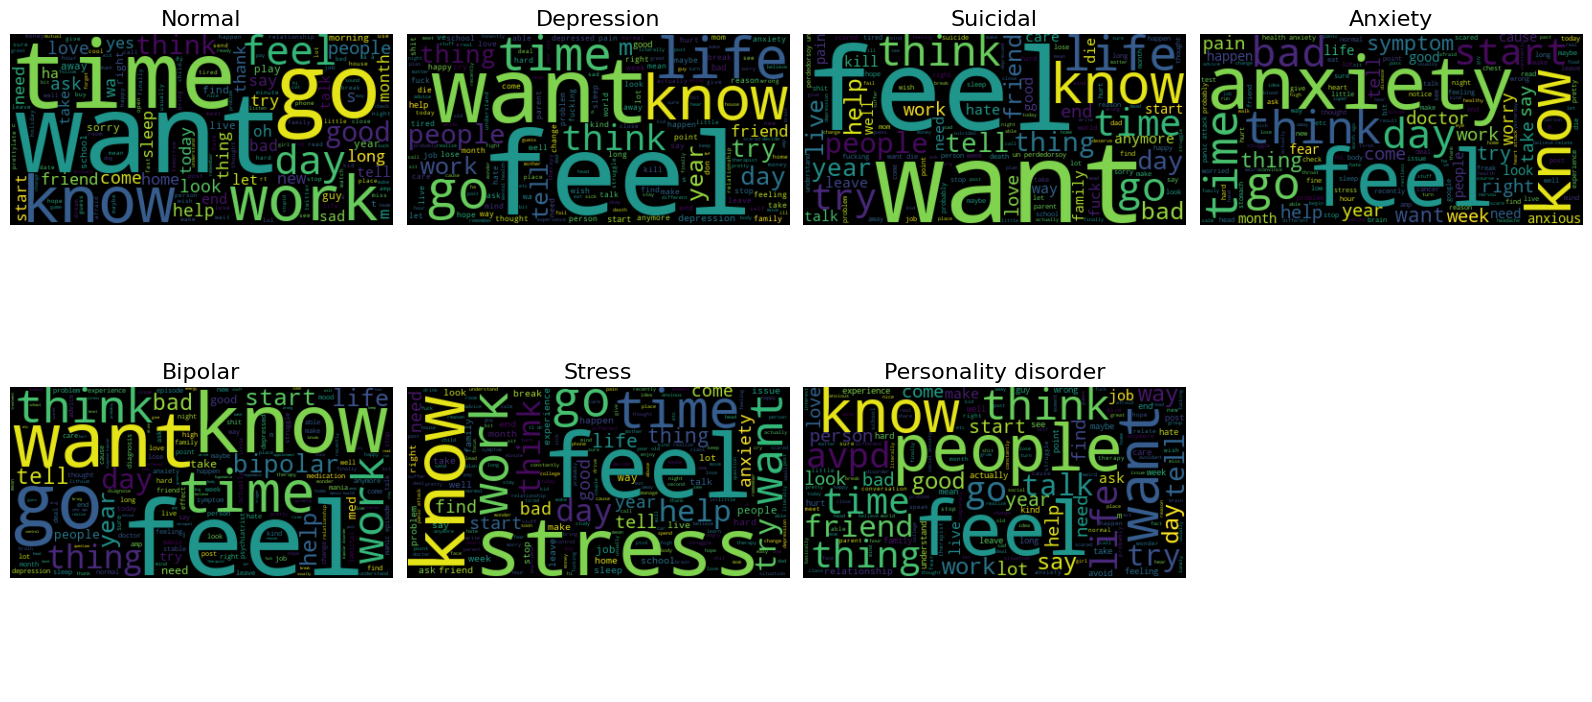

In [21]:
fig, axes = plt.subplots(2, 4, figsize=(16, 8), constrained_layout=True)
axes = axes.flatten()  # Flatten to easily iterate

for i, name in enumerate(target):
    # Generate text for this category
    text = ' '.join(df_balanced[df_balanced.category_num == i].proc_statement)
    # Generate word cloud
    wordcloud = WordCloud(background_color="black")
    wordcloud.generate(text)
    # Plot on subplot
    axes[i].imshow(wordcloud.recolor(colormap='viridis', random_state=17), interpolation='bilinear')
    axes[i].set_title(name, fontsize=16)
    axes[i].axis('off')
    
# Hide the last (8th) subplot if unused
if len(target) < len(axes):
    for j in range(len(target), len(axes)):
        axes[j].axis('off')
plt.tight_layout(pad=1.0, h_pad=0.5, w_pad=1.0)
plt.show()


As

# Prediction using ML models 
After the preprocessing, I will use different machine learning models to predict the sentiment of the text data. for this I will use bag of ngrams and TF-IDF to vectorize the text data and see the differt results, then I will try other ML algorithms for classification.

In [22]:
from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(df_balanced.proc_statement, df_balanced.category_num,
                                                    random_state=seed, 
                                                    test_size=0.2,
                                                    stratify=df_balanced.category_num)


For the vectoprization, I will use bag of n-grams.

                      precision    recall  f1-score   support

              Normal       1.00      0.04      0.07       216
          Depression       0.39      0.47      0.42       216
            Suicidal       0.55      0.62      0.58       216
             Anxiety       0.65      0.80      0.71       215
             Bipolar       0.55      0.82      0.66       215
              Stress       0.79      0.24      0.37       215
Personality disorder       0.53      0.86      0.66       215

            accuracy                           0.55      1508
           macro avg       0.64      0.55      0.50      1508
        weighted avg       0.64      0.55      0.50      1508



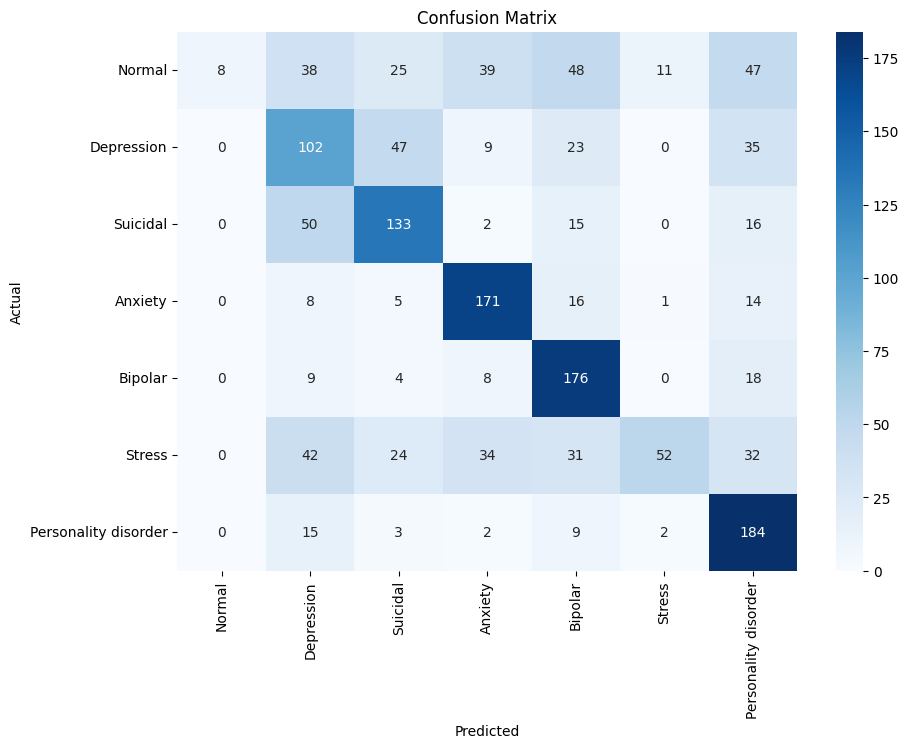

In [23]:
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import confusion_matrix


clf_nb = Pipeline([
    ('vectorize_n_Grams', CountVectorizer(ngram_range=(1,2))),
    ('Naive Bayes', MultinomialNB())])

clf_nb.fit(X_train,y_train)
y_pred = clf_nb.predict(X_test)
print(classification_report(y_test,y_pred,target_names=target))


# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target.keys(), yticklabels=target.keys(), cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

I will check the results using TF-IDF and bag of n-grams and compare the results of different models.

                      precision    recall  f1-score   support

              Normal       0.95      0.18      0.30       216
          Depression       0.47      0.52      0.50       216
            Suicidal       0.57      0.75      0.65       216
             Anxiety       0.68      0.78      0.73       215
             Bipolar       0.66      0.80      0.73       215
              Stress       0.70      0.41      0.52       215
Personality disorder       0.59      0.87      0.70       215

            accuracy                           0.61      1508
           macro avg       0.66      0.61      0.59      1508
        weighted avg       0.66      0.61      0.59      1508



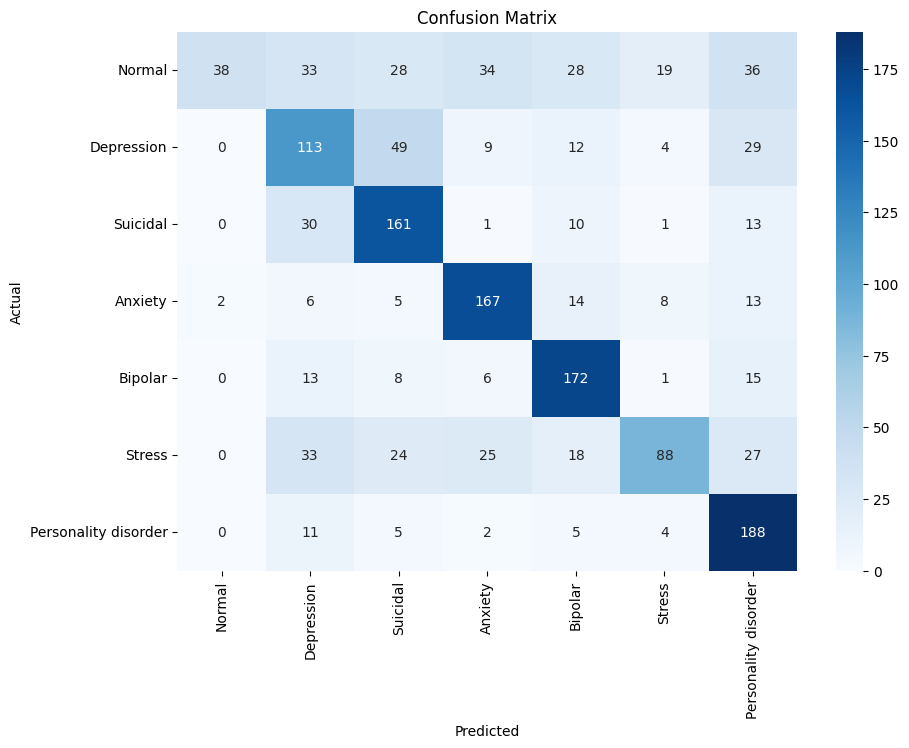

In [24]:
from sklearn.feature_extraction.text import TfidfVectorizer

clf_nb_tfid = Pipeline([
    ('vectorize_TFID', TfidfVectorizer()), # I will try again with TFIDF method to see the difference in performance 
    ('Naive Bayes', MultinomialNB())])

clf_nb_tfid.fit(X_train,y_train)
y_pred = clf_nb_tfid.predict(X_test)
print(classification_report(y_test,y_pred,target_names=target))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target.keys(), yticklabels=target.keys(), cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

                      precision    recall  f1-score   support

              Normal       0.77      0.76      0.77       216
          Depression       0.51      0.45      0.48       216
            Suicidal       0.60      0.69      0.64       216
             Anxiety       0.78      0.84      0.81       215
             Bipolar       0.84      0.80      0.82       215
              Stress       0.67      0.60      0.64       215
Personality disorder       0.78      0.80      0.79       215

            accuracy                           0.71      1508
           macro avg       0.71      0.71      0.71      1508
        weighted avg       0.71      0.71      0.71      1508



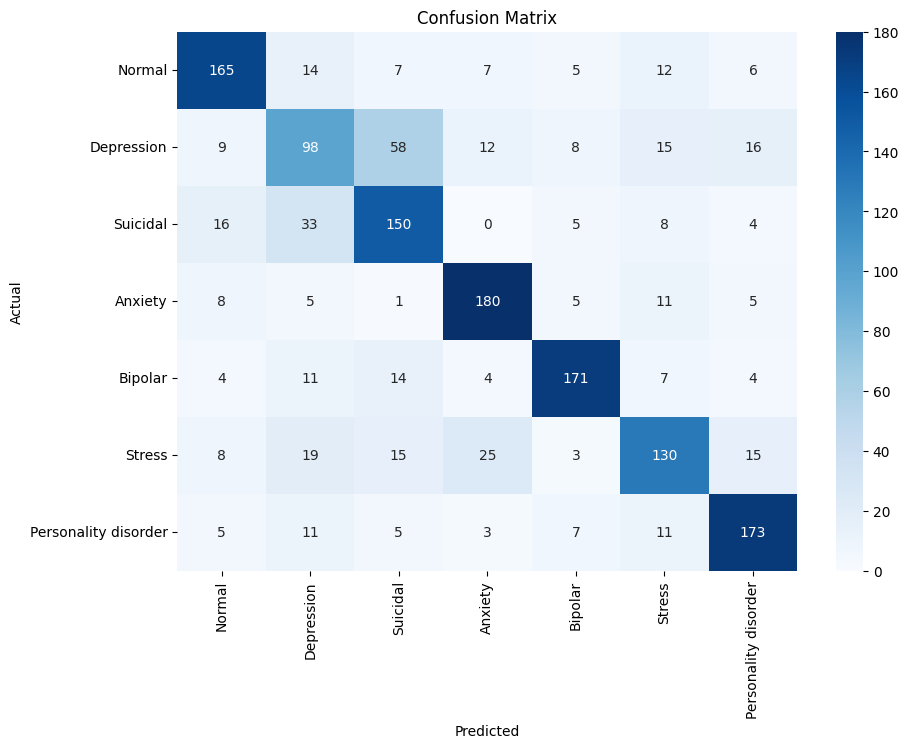

In [25]:
from sklearn.svm import LinearSVC
from sklearn.model_selection import GridSearchCV

# Pipeline with TFIDF + SVM
clf_SVC_tfid = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
    ('classifier', LinearSVC())])
# setting some hyperparameter selction for fine tuning, I already saw that TFIDF works better for this case 
svc_param_grid = {
    'classifier__penalty': ['l2'],  # 'l1' only with dual=False
    'classifier__C': np.linspace(10, 100, num=8),
    'classifier__max_iter': [500,1000]}


# GridSearch with correct param names
best_params = GridSearchCV(clf_SVC_tfid, svc_param_grid, cv=5, n_jobs=-1)
best_params.fit(X_train, y_train)
y_pred = best_params.predict(X_test)

print(classification_report(y_test,y_pred,target_names=target))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target.keys(), yticklabels=target.keys(), cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [26]:
best_params.best_params_

{'classifier__C': np.float64(10.0),
 'classifier__max_iter': 500,
 'classifier__penalty': 'l2'}

A it can be seen, SVM are outperforming Naive Bayes, however, I will try other models such as XGBoost to see if they can improve the results. XGBosot is better to detect some non-linear relationships, so it can be a good option to try, however is more computationally expensive.

In [27]:
from xgboost import XGBClassifier

# Pipeline
clf_XGB_tfid = Pipeline([
    ('vectorizer', TfidfVectorizer(ngram_range=(1, 2))),
    ('classifier', XGBClassifier(tree_method='hist', random_state=101))])

# Parameter Grid
XGB_param_grid = {
    'classifier__learning_rate': [0.1, 0.5],
    'classifier__max_depth': [5, 7],
    'classifier__n_estimators': [200]}

# Grid Search
best_params = GridSearchCV(clf_XGB_tfid, XGB_param_grid, cv=5, n_jobs=-1)
best_params.fit(X_train, y_train)

# Predictions
y_pred = best_params.predict(X_test)


Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
                      precision    recall  f1-score   support

              Normal       0.67      0.93      0.78       216
          Depression       0.52      0.44      0.47       216
            Suicidal       0.56      0.62      0.59       216
             Anxiety       0.79      0.74      0.77       215
             Bipolar       0.89      0.77      0.83       215
              Stress       0.66      0.62      0.64       215
Personality disorder       0.77      0.69      0.73       215

            accuracy                           0.69      1508
           macro avg       0.69      0.69      0.69      1508
        weighted avg       0.69      0.69      0.69      1508



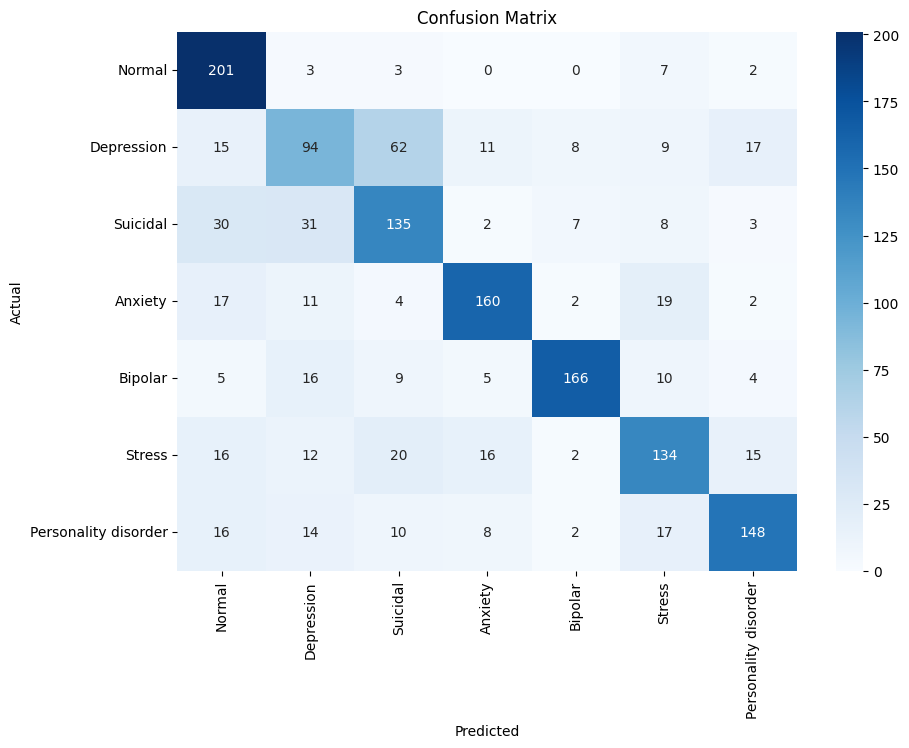

In [28]:

# Report
print("Best Parameters:", best_params.best_params_)
print(classification_report(y_test, y_pred, target_names=list(target.keys())))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target.keys(), yticklabels=target.keys(), cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [29]:
# Save the best model
import joblib
import os
try:
    joblib.dump(best_params, '../models/xgb_mental_health_model.pkl')
except :
    print("Models directory does not exist, creating it.")
    os.mkdir("../models")
    joblib.dump(best_params, '../models/xgb_mental_health_model.pkl')

In this case XGBoost has a good behaviur, however it is detecting many false negatives, in the case of mental heath for depression, anxiety and stress, this is not a good thing, as it can lead to a wrong diagnosis. So I will try to improve the model with some weihghting of the classes, so the model can prioritize the classes, in this case is better to check a person with a false positive than a false negative.

Best Parameters: {'classifier__learning_rate': 0.1, 'classifier__max_depth': 5, 'classifier__n_estimators': 200}
                      precision    recall  f1-score   support

              Normal       0.72      0.92      0.80       216
          Depression       0.54      0.45      0.49       216
            Suicidal       0.53      0.67      0.59       216
             Anxiety       0.79      0.75      0.77       215
             Bipolar       0.88      0.77      0.82       215
              Stress       0.66      0.60      0.63       215
Personality disorder       0.77      0.69      0.73       215

            accuracy                           0.69      1508
           macro avg       0.70      0.69      0.69      1508
        weighted avg       0.70      0.69      0.69      1508



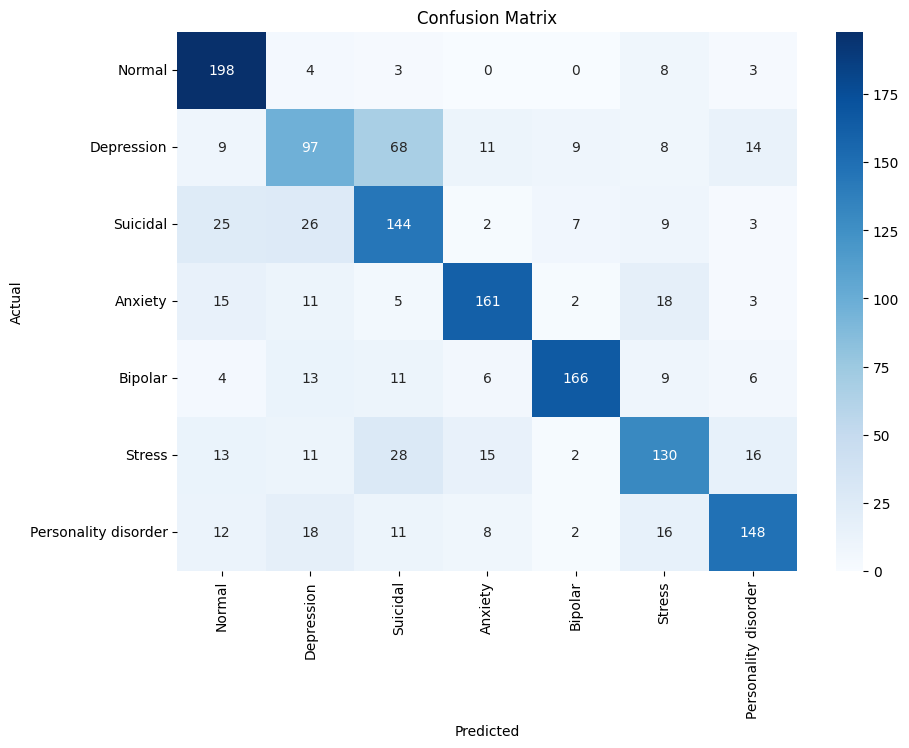

In [30]:
from sklearn.utils.class_weight import compute_sample_weight

# Define class weights
class_weights = {
    0: 0.8,  # Normal
    1: 1.3, # Depression
    2: 1.5, # Suicidal
    3: 1.2, # Anxiety 
    4: 1.2, # Bipolar
    5: 1.2, # Stress
    6: 1.2, # Personality disorder
}

# Compute sample weights
sample_weights = compute_sample_weight(class_weight=class_weights, y=y_train)

# Vectorize manually
vectorizer = TfidfVectorizer(ngram_range=(1, 2))
X_train_vec = vectorizer.fit_transform(X_train)
X_test_vec = vectorizer.transform(X_test)

xgb_best_params = {k.replace("classifier__", ""): v for k, v in best_params.best_params_.items()}

# Instantiate classifier with best params
classifier = XGBClassifier(**xgb_best_params)

# Fit with sample weights
classifier.fit(X_train_vec, y_train, sample_weight=sample_weights)

# Predict
y_pred = classifier.predict(X_test_vec)

# Report
print("Best Parameters:", best_params.best_params_)
print(classification_report(y_test, y_pred, target_names=list(target.keys())))

# Confusion Matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target.keys(), yticklabels=target.keys(), cmap='Blues')
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

## Improiving the model using oversampling and SMOTE

https://www.youtube.com/watch?v=JnlM4yLFNuo

### Oversampling
In this case oversampling will help to balance the dataset, however it can lead to overfitting, if using repeated data. 

In [31]:
df_mh[df_mh.statement.isna() == False].status.value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

In [32]:
category = list(target.keys())
category

['Normal',
 'Depression',
 'Suicidal',
 'Anxiety',
 'Bipolar',
 'Stress',
 'Personality disorder']

In [33]:

max_samples = int(df_mh[df_mh['status']=='Normal']['statement'].count())
min_samples = int(df_mh[df_mh['status']=='Personality disorder']['statement'].count())
test_sample = round(0.2*min_samples)

print("max number of samples in a category:", max_samples)
print("min number of samples in a category:", min_samples)
print("Size of the sample:", test_sample)

max number of samples in a category: 16343
min number of samples in a category: 1077
Size of the sample: 215


In [34]:
df_mh.dropna(inplace=True)
#df_mh['processed_statement']= df_mh['statement'].apply(preprocessing)
df_mh.head()

,statement,status,proc_statement
0,oh my gosh,Anxiety,oh gosh
1,"trouble sleeping, confused mind, restless hear...",Anxiety,trouble sleep confused mind restless heart tune
2,"All wrong, back off dear, forward doubt. Stay ...",Anxiety,wrong dear forward doubt stay restless restles...
3,I've shifted my focus to something else but I'...,Anxiety,shift focus worried
4,"I'm restless and restless, it's been a month n...",Anxiety,restless restless month boy mean


In [35]:
seed = 200
def take_sample(X,y,test_sample,seed):
    X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=test_sample, random_state=seed)
    df_new_train = pd.concat([X_train,y_train], axis=1)
    df_new_test = pd.concat([X_test,y_test],axis=1)
    return df_new_train, df_new_test


In [36]:
df_normal_over, df_normal_test = take_sample(df_mh[df_mh.status == category[0]].proc_statement,df_mh[df_mh.status == category[0]].status, test_sample, seed)

In [37]:
test_data = []
train_data = []

for i,cat in enumerate(category):
    train, test = take_sample(df_mh[df_mh.status == cat].proc_statement, df_mh[df_mh.status == cat].status, test_sample, seed)
    train = train.sample(max_samples,random_state=seed,replace=True)
    train_data.append(train)
    test_data.append(test)
    
df_mh_train = pd.concat(train_data,axis=0)
df_mh_test = pd.concat(test_data, axis=0)

print(df_mh_train.status.value_counts())
print(df_mh_test.status.value_counts())

status
Normal                  16343
Depression              16343
Suicidal                16343
Anxiety                 16343
Bipolar                 16343
Stress                  16343
Personality disorder    16343
Name: count, dtype: int64
status
Normal                  215
Depression              215
Suicidal                215
Anxiety                 215
Bipolar                 215
Stress                  215
Personality disorder    215
Name: count, dtype: int64


In [38]:
df_mh_train.head()

,proc_statement,status
3511,oh god sleepy,Normal
3791,thr want ask good day give delicious foodðÿ˜,Normal
43336,sooo proud bro huhu s talentfull wish well like,Normal
28291,turn month start friendly catch thing get ...,Normal
4967,strong girl patient long time patience appreciate,Normal


In [39]:

target = {"Normal"                :0, 
           "Depression"           :1,
           "Suicidal"             :2,
           "Anxiety"              :3,
           "Bipolar"              :4,
           "Stress"               :5,
           "Personality disorder" :6}
df_mh_train['category_num'] = df_mh_train.status.map(target)
df_mh_test['category_num'] = df_mh_test.status.map(target)
df_mh_train

,proc_statement,status,category_num
3511,oh god sleepy,Normal,0
3791,thr want ask good day give delicious foodðÿ˜,Normal,0
43336,sooo proud bro huhu s talentfull wish well like,Normal,0
28291,turn month start friendly catch thing get ...,Normal,0
4967,strong girl patient long time patience appreciate,Normal,0
...,...,...,...
50882,people include socially wanna know like sad fe...,Personality disorder,6
51854,bunch dxm yesterday realize reason like view p...,Personality disorder,6
51426,annoying habit sigh sigh lot habit develop yea...,Personality disorder,6
51651,sick think hate go child friend family mem...,Personality disorder,6


In [40]:
df_mh_train.to_csv('../data/mental_health/processed_mental_health_data_oversampled_train.csv')
df_mh_test.to_csv('../data/mental_health/processed_mental_health_data_oversampled_test.csv')


                      precision    recall  f1-score   support

              Normal       0.99      0.32      0.48       215
          Depression       0.42      0.62      0.50       215
            Suicidal       0.60      0.61      0.60       215
             Anxiety       0.76      0.84      0.80       215
             Bipolar       0.65      0.80      0.72       215
              Stress       0.68      0.49      0.57       215
Personality disorder       0.68      0.74      0.71       215

            accuracy                           0.63      1505
           macro avg       0.68      0.63      0.63      1505
        weighted avg       0.68      0.63      0.63      1505



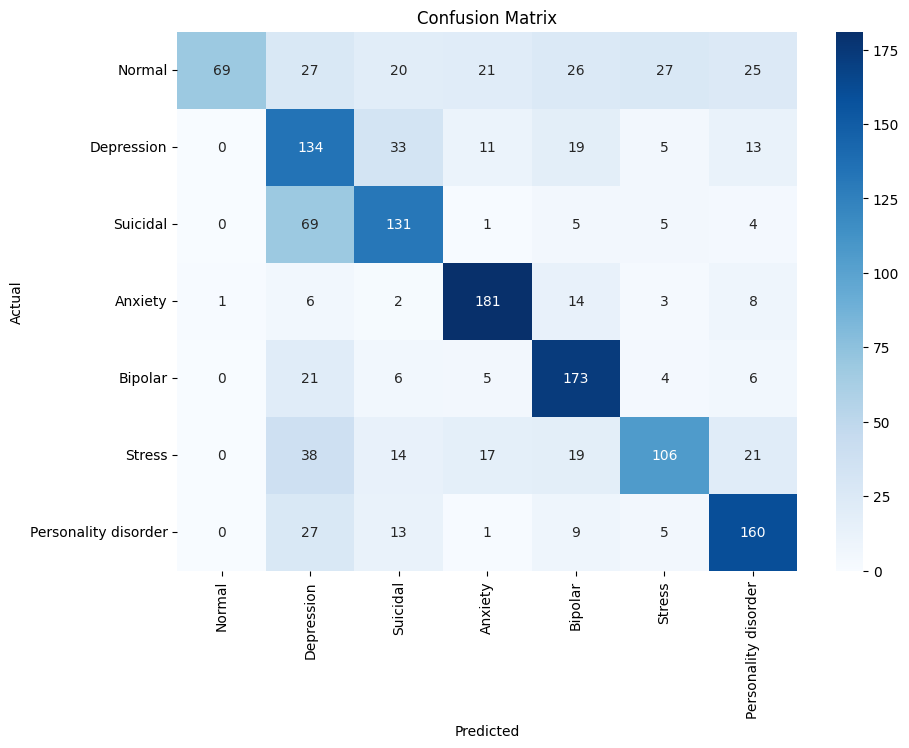

Pipeline(steps=[('vectorize_TFIDF', TfidfVectorizer(ngram_range=(1, 2))),
                ('Naive_bayes', MultinomialNB())])

In [41]:
import sklearn
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix



X_train, X_test, y_train, y_test = df_mh_train.proc_statement, df_mh_test.proc_statement, df_mh_train.category_num, df_mh_test.category_num

def train_test_pipeline_tfidf(X_train, X_test, y_train, y_test,model,model_name):
    clf_nb = Pipeline([
        ('vectorize_TFIDF', TfidfVectorizer(ngram_range=(1,2))),
        (model_name, model)])

    clf_nb.fit(X_train,y_train)
    y_pred = clf_nb.predict(X_test)
    print(classification_report(y_test,y_pred,target_names=target))
    
    # Compute confusion matrix
    cm = confusion_matrix(y_test, y_pred)
    # Plot heatmap
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=target.keys(), yticklabels=target.keys(), cmap='Blues')

    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title('Confusion Matrix')
    plt.show()
    
    return clf_nb

train_test_pipeline_tfidf(X_train, X_test, y_train, y_test,MultinomialNB(),'Naive_bayes')

## SMOTE

In [42]:
from imblearn.over_sampling import SMOTE 

df_mh_train= pd.read_csv('../data/mental_health/processed_mental_health_data_oversampled_train.csv')
df_mh_test=pd.read_csv('../data/mental_health/processed_mental_health_data_oversampled_test.csv')

In [43]:
df_mh['status'].value_counts()

status
Normal                  16343
Depression              15404
Suicidal                10652
Anxiety                  3841
Bipolar                  2777
Stress                   2587
Personality disorder     1077
Name: count, dtype: int64

In [44]:
y = df_mh.status.map(target)


In [45]:
train_data = []
test_data = []
for i,cat in enumerate(category):
    train, test = take_sample(df_mh[df_mh.status == cat].proc_statement, df_mh[df_mh.status == cat].status, test_sample, seed)
    train_data.append(train)
    test_data.append(test)
    
df_mh_train = pd.concat(train_data,axis=0)
df_mh_test = pd.concat(test_data, axis=0)

print(df_mh_train.status.value_counts())
print(df_mh_test.status.value_counts())

status
Normal                  16128
Depression              15189
Suicidal                10437
Anxiety                  3626
Bipolar                  2562
Stress                   2372
Personality disorder      862
Name: count, dtype: int64
status
Normal                  215
Depression              215
Suicidal                215
Anxiety                 215
Bipolar                 215
Stress                  215
Personality disorder    215
Name: count, dtype: int64


In [46]:
X_init = df_mh_train.proc_statement
X_init

43723              gerrycoe hi gerry m dublin time college
1852                                              gun love
43294                    imperiusrex brahbrah ugh bed hour
3469       account post ig appearing story viewer accid...
32229                                                taste
                               ...                        
51031    happy worried warm weather start warm spring c...
51593    interview anxiety hi i’ve job search august of...
51554    relate wanna know guy relate point try speak l...
51524    friend text manage   reply ignore feel awful p...
51342    life activity wanna honestly know existence co...
Name: proc_statement, Length: 51176, dtype: object

For SMOTE I need the X dataframe as a vectorized dataframe, so I will use the same vectorization, before applying SMOTE.

In [47]:
from sklearn.feature_extraction.text import TfidfVectorizer

vec = TfidfVectorizer(ngram_range=(1,2))
X_vec = vec.fit_transform(X_init)
y = df_mh_train.status.map(target)


In [48]:
smote = SMOTE(random_state=101)
X_sm, y_sm = smote.fit_resample(X_vec, y)

y_sm.value_counts()

status
0    16128
1    16128
2    16128
3    16128
4    16128
5    16128
6    16128
Name: count, dtype: int64

                      precision    recall  f1-score   support

              Normal       0.99      0.33      0.50       215
          Depression       0.34      0.73      0.46       215
            Suicidal       0.65      0.32      0.43       215
             Anxiety       0.77      0.81      0.79       215
             Bipolar       0.63      0.83      0.72       215
              Stress       0.78      0.39      0.52       215
Personality disorder       0.66      0.74      0.70       215

            accuracy                           0.59      1505
           macro avg       0.69      0.59      0.59      1505
        weighted avg       0.69      0.59      0.59      1505



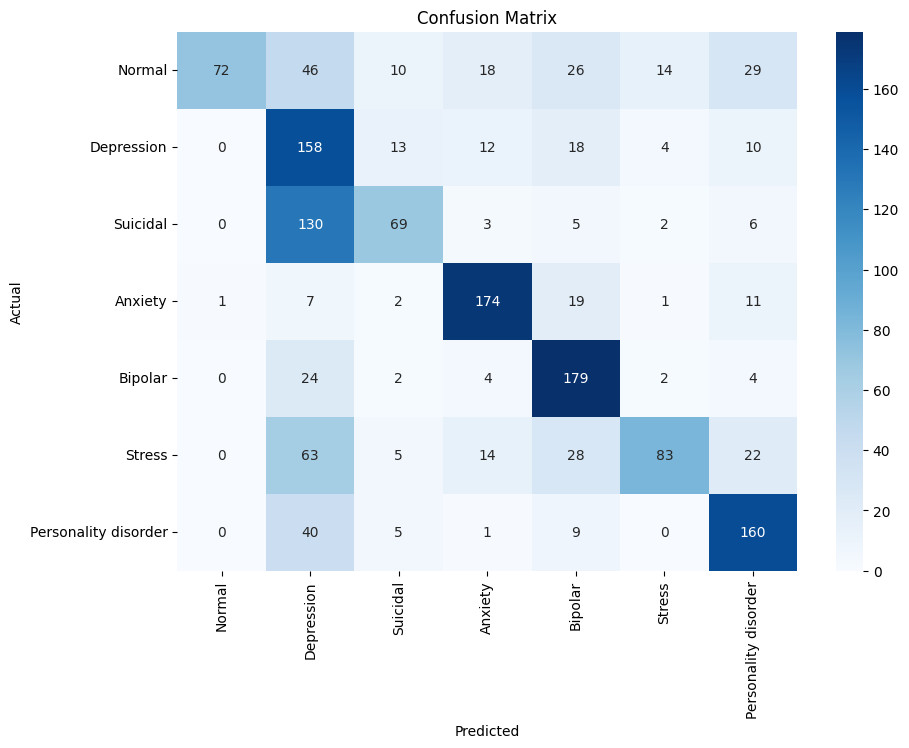

In [49]:
y_test = df_mh_test.status.map(target)
X_test = vec.transform(df_mh_test.proc_statement) 

clf = MultinomialNB()

clf.fit(X_sm,y_sm)
y_pred = clf.predict(X_test)

print(classification_report(y_test,y_pred,target_names=target))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target.keys(), yticklabels=target.keys(), cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

In [ ]:
model = LinearSVC()
svc_param_grid = {
    'penalty': ['l2'],  #
    'C': np.linspace(5, 20, num=3)}

clf_scv = GridSearchCV(model,svc_param_grid, cv=5)
clf_scv.fit(X_sm,y_sm)
y_pred = clf_scv.predict(X_test)

print(classification_report(y_test,y_pred,target_names=target))

# Compute confusion matrix
cm = confusion_matrix(y_test, y_pred)
# Plot heatmap
plt.figure(figsize=(10, 7))
sns.heatmap(cm, annot=True, fmt='d', xticklabels=target.keys(), yticklabels=target.keys(), cmap='Blues')

plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

c:\Users\hecma\anaconda3\envs\ML_projects\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\hecma\anaconda3\envs\ML_projects\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\hecma\anaconda3\envs\ML_projects\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(
c:\Users\hecma\anaconda3\envs\ML_projects\Lib\site-packages\sklearn\svm\_base.py:1249: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


# Model Summary 

|   	|          Model         	|   Vectorizer   	| Sampling Type 	| Accuracy 	| Macro Precision 	| Macro Recall 	| Macro F1 	|
|---	|:----------------------:	|:--------------:	|:-------------:	|:--------:	|:---------------:	|:------------:	|:--------:	|
| 3 	| Linear SVC             	| TF-IDF (1,2)   	| Undersampling 	| 0.71     	| 0.71            	| 0.71         	| 0.71     	|
| 5 	| XGBoost (with weights) 	| TF-IDF (1,2)   	| Undersampling 	| 0.69     	| 0.7             	| 0.69         	| 0.69     	|
| 4 	| XGBoost                	| TF-IDF (1,2)   	| Undersampling 	| 0.69     	| 0.69            	| 0.69         	| 0.69     	|
| 8 	| Linear SVC (C=10.0)    	| TF-IDF (1,2)   	| SMOTE         	| 0.67     	| 0.72            	| 0.67         	| 0.68     	|
| 6 	| Multinomial NB         	| TF-IDF (1,2)   	| Oversampling  	| 0.63     	| 0.68            	| 0.63         	| 0.63     	|
| 2 	| Multinomial NB         	| TF-IDF (1,1)   	| Undersampling 	| 0.61     	| 0.66            	| 0.61         	| 0.59     	|
| 7 	| Multinomial NB         	| TF-IDF (1,2)   	| SMOTE         	| 0.59     	| 0.69            	| 0.59         	| 0.59     	|
| 1 	| Multinomial NB         	| n-grams  (1,2) 	| Undersampling 	| 0.55     	| 0.64            	| 0.55         	| 0.5      	|